<a href="https://colab.research.google.com/github/jjungmini/solar/blob/main/%EC%95%88%EC%A0%95%EB%AF%BC_230912_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install h2o

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import h2o
from h2o.automl import H2OAutoML
import seaborn as sns
from prophet import Prophet

In [3]:
import itertools
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

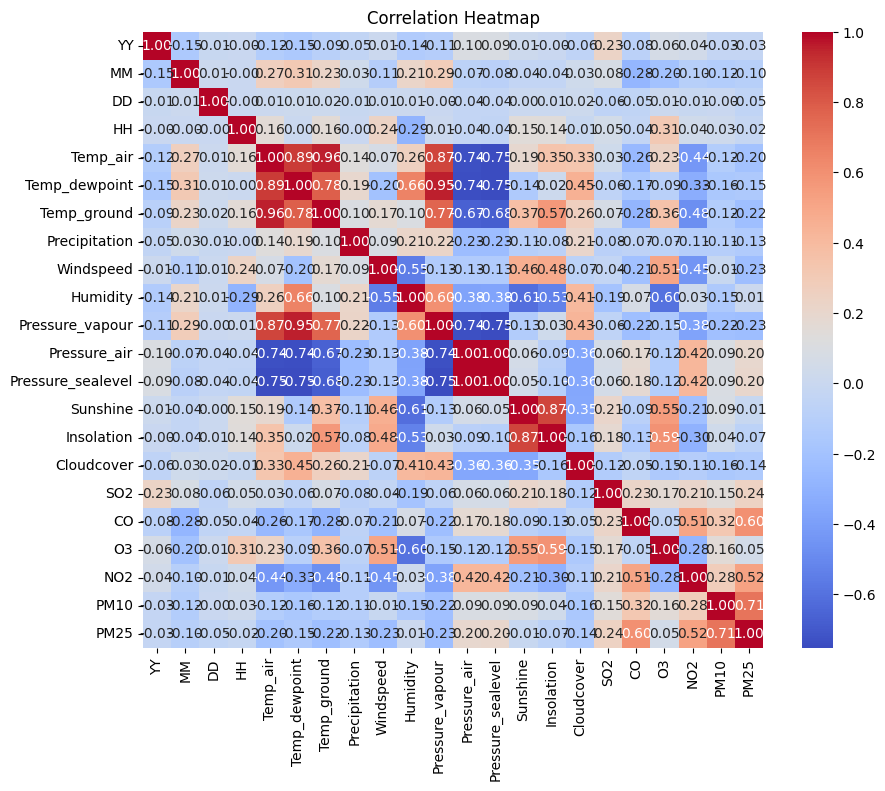

In [4]:
# 데이터 로딩
df = pd.read_csv('solar_with_emissions_0228.csv')

# 날짜를 datetime 타입으로 변환
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d-%H')

# 타겟 변수를 위한 별도의 스케일러 정의
target_scaler = MinMaxScaler()
df['Solarpower'] = target_scaler.fit_transform(df[['Solarpower']])

# 특성만 정규화하기 위해 Scaler 정의
scaler = MinMaxScaler()

# 특성들 간의 상관관계 계산을 위해 타겟 변수 제외
correlation_matrix = df.drop(columns=['Date', 'Solarpower']).corr()

# 상관관계 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [5]:
# Solarpower 제외하고 정규화
features = df.drop(columns=['Date', 'Solarpower'])
scaled_features = scaler.fit_transform(features)
df[features.columns] = scaled_features

# 훈련 데이터와 테스트 데이터로 분리
train = df[df['Date'] < '2022-12-01']
test = df[(df['Date'] >= '2022-12-01') & (df['Date'] < '2023-01-01')]

In [6]:
test

,Date,YY,MM,DD,HH,Solarpower,Temp_air,Temp_dewpoint,Temp_ground,Precipitation,...,Pressure_sealevel,Sunshine,Insolation,Cloudcover,SO2,CO,O3,NO2,PM10,PM25
25560,2022-12-01 00:00:00,0.666667,1.0,0.0,0.000000,0.002385,0.241926,0.201322,0.161320,0.0,...,0.910823,0.0,0.0,0.935714,0.255555,0.222222,0.275758,0.124510,0.011885,0.049689
25561,2022-12-01 01:00:00,0.666667,1.0,0.0,0.043478,0.000186,0.238256,0.209722,0.161776,0.0,...,0.910720,0.0,0.0,1.000000,0.277778,0.222222,0.284848,0.096078,0.011205,0.033126
25562,2022-12-01 02:00:00,0.666667,1.0,0.0,0.086957,0.001703,0.235320,0.220050,0.159379,0.0,...,0.911647,0.0,0.0,0.964286,0.272222,0.222222,0.287879,0.099020,0.010866,0.039337
25563,2022-12-01 03:00:00,0.666667,1.0,0.0,0.130435,0.001827,0.234733,0.231479,0.160064,0.0,...,0.912161,0.0,0.0,0.957143,0.277778,0.222222,0.293939,0.075490,0.010866,0.055901
25564,2022-12-01 04:00:00,0.666667,1.0,0.0,0.173913,0.000898,0.234880,0.241669,0.159151,0.0,...,0.903717,0.0,0.0,0.957143,0.283333,0.222222,0.300000,0.070588,0.011885,0.043478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2022-12-31 19:00:00,0.666667,1.0,1.0,0.826087,0.101992,0.314739,0.364638,0.154241,0.0,...,0.881372,0.0,0.0,0.000000,0.238889,0.370370,0.290909,0.205882,0.031919,0.132505
26300,2022-12-31 20:00:00,0.666667,1.0,1.0,0.869565,0.081798,0.291544,0.362159,0.146364,0.0,...,0.885388,0.0,0.0,0.000000,0.250000,0.333333,0.315152,0.220588,0.034975,0.151139
26301,2022-12-31 21:00:00,0.666667,1.0,1.0,0.913043,0.056834,0.276864,0.363261,0.139856,0.0,...,0.887653,0.0,0.0,0.007143,0.244445,0.370370,0.293939,0.201471,0.039389,0.167702
26302,2022-12-31 22:00:00,0.666667,1.0,1.0,0.956522,0.031127,0.255432,0.361195,0.133349,0.0,...,0.884873,0.0,0.0,0.107143,0.238889,0.407407,0.236364,0.200000,0.041087,0.202899


# FEATURE SELECTION

In [7]:
# 훈련 데이터를 이용하여 특성 선택을 위한 ElasticNetCV 모델을 생성합니다
enet_train = ElasticNetCV(
    alphas=[0.001, 0.01, 0.1, 1, 10],        # 후보 alpha 값 리스트
    l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],     # 후보 l1_ratio 값 리스트
    cv=5,                                   # 5-fold cross-validation 사용
    n_alphas=1000,                           # 100개의 alpha 값 생성
    max_iter=1000,                          # 최대 반복 횟수
    tol=1e-4,                               # 수렴 기준
    verbose=False,                          # 로그 출력 비활성화
    precompute='auto',                      # 자동으로 사전 계산된 Gram 행렬 결정
    selection='random',                      # 랜덤하게 특성 선택
    random_state=42
)
enet_train.fit(train.drop(columns=['Date', 'Solarpower', 'YY', 'MM', 'DD', 'HH', 'Pressure_sealevel', 'CO', 'O3', 'NO2']), train['Solarpower'])
# alpha 값을 출력합니다.
print('Best alpha: ', enet_train.alpha_)

# 선택된 특성만 남김
selected_features_train = train.drop(columns=['Date', 'Solarpower',  'YY', 'MM', 'DD', 'HH', 'Pressure_sealevel', 'CO', 'O3', 'NO2']).columns[enet_train.coef_ != 0]
train = train[['Date', 'Solarpower'] + selected_features_train.tolist()]

# 선택된 특성 출력
print("Selected features: ", selected_features_train.tolist())

Best alpha:  0.001
Selected features:  ['Temp_air', 'Windspeed', 'Pressure_air', 'Sunshine', 'Insolation', 'SO2']


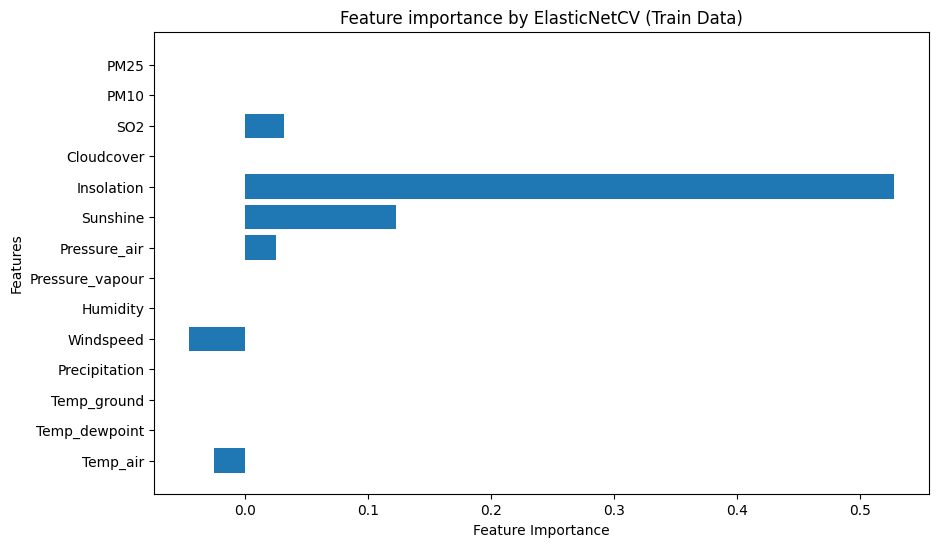

In [8]:
# ElasticNetCV의 결과를 출력합니다.
# 특성 중요도를 시각화합니다.
plt.figure(figsize=(10, 6))
plt.barh(range(len(enet_train.coef_)), enet_train.coef_)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.yticks(range(len(enet_train.coef_)), enet_train.feature_names_in_)
plt.title('Feature importance by ElasticNetCV (Train Data)')
plt.show()

In [9]:
train

,Date,Solarpower,Temp_air,Windspeed,Pressure_air,Sunshine,Insolation,SO2
0,2020-01-01 00:00:00,0.003779,0.180417,0.234509,0.917782,0.0,0.0,0.183333
1,2020-01-01 01:00:00,0.001239,0.176453,0.246902,0.918305,0.0,0.0,0.194444
2,2020-01-01 02:00:00,0.000805,0.167499,0.239276,0.921234,0.0,0.0,0.205556
3,2020-01-01 03:00:00,0.000000,0.160893,0.195424,0.917469,0.0,0.0,0.211111
4,2020-01-01 04:00:00,0.001208,0.162654,0.224023,0.914435,0.0,0.0,0.244445
...,...,...,...,...,...,...,...,...
25555,2022-11-30 19:00:00,0.086443,0.281415,0.297426,0.893724,0.0,0.0,0.272222
25556,2022-11-30 20:00:00,0.052312,0.273341,0.326025,0.898431,0.0,0.0,0.261111
25557,2022-11-30 21:00:00,0.022765,0.266001,0.346044,0.902615,0.0,0.0,0.272222
25558,2022-11-30 22:00:00,0.008146,0.257780,0.348904,0.906904,0.0,0.0,0.261111


# prophet

In [10]:
#prophet 학습 데이터 생성
prophet_train = train.rename(columns={'Date':'ds', 'Solarpower':'y'})
prophet_train = prophet_train[['ds', 'y'] + selected_features_train.tolist()]
prophet_train

,ds,y,Temp_air,Windspeed,Pressure_air,Sunshine,Insolation,SO2
0,2020-01-01 00:00:00,0.003779,0.180417,0.234509,0.917782,0.0,0.0,0.183333
1,2020-01-01 01:00:00,0.001239,0.176453,0.246902,0.918305,0.0,0.0,0.194444
2,2020-01-01 02:00:00,0.000805,0.167499,0.239276,0.921234,0.0,0.0,0.205556
3,2020-01-01 03:00:00,0.000000,0.160893,0.195424,0.917469,0.0,0.0,0.211111
4,2020-01-01 04:00:00,0.001208,0.162654,0.224023,0.914435,0.0,0.0,0.244445
...,...,...,...,...,...,...,...,...
25555,2022-11-30 19:00:00,0.086443,0.281415,0.297426,0.893724,0.0,0.0,0.272222
25556,2022-11-30 20:00:00,0.052312,0.273341,0.326025,0.898431,0.0,0.0,0.261111
25557,2022-11-30 21:00:00,0.022765,0.266001,0.346044,0.902615,0.0,0.0,0.272222
25558,2022-11-30 22:00:00,0.008146,0.257780,0.348904,0.906904,0.0,0.0,0.261111


In [11]:
# MAPE 계산 함수 정의
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4_ewxbf/4qw4i9n3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4_ewxbf/949a3qga.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40482', 'data', 'file=/tmp/tmpb4_ewxbf/4qw4i9n3.json', 'init=/tmp/tmpb4_ewxbf/949a3qga.json', 'output', 'file=/tmp/tmpb4_ewxbf/prophet_modelay89pqoa/prophet_model-20230912131847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-11-d65f9915a241>:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


평균 제곱 오차 (MSE): 1194.4796993740426
평균 절대 오차 (MAE): 24.052928224682432
결정 계수 (R2): 0.7794460106118543
평균 절대 백분율 오차 (MAPE): inf
평균 제곱근 오차 (RMSE): 34.56124562821836


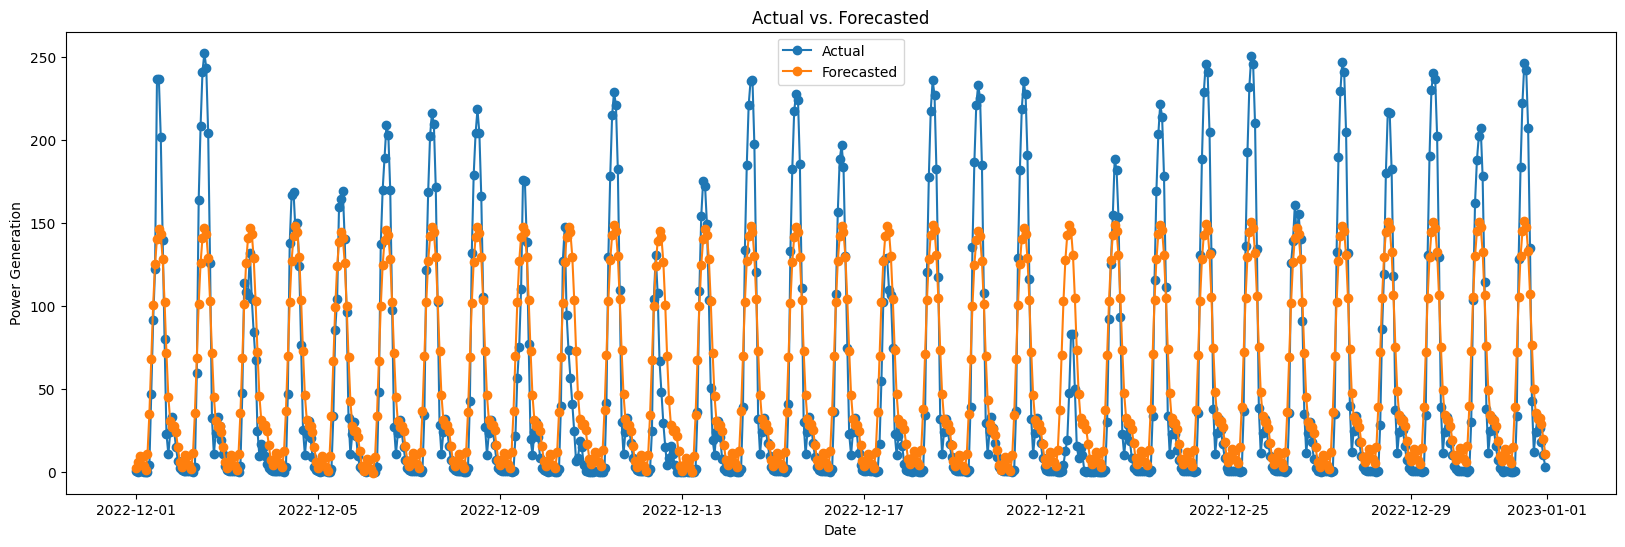

In [12]:
#튜닝 안한거
m = Prophet()
m.fit(prophet_train)
future = m.make_future_dataframe(periods=len(test), freq='H')
forecast = m.predict(future)
forecast_test = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(len(test))
#예측된 값을 원래 스케일로 역변환
predictions= target_scaler.inverse_transform(forecast_test.yhat.values.reshape(-1,1))
# 테스트 데이터셋의 실제 타겟 변수 값을 가져옴
actual_values = test['Solarpower'].values.reshape(-1, 1)
actual_values = target_scaler.inverse_transform(actual_values)
# 평가 지표 계산
mse = mean_squared_error(actual_values, predictions)
mae = mean_absolute_error(actual_values, predictions)
r2 = r2_score(actual_values, predictions)
mape = mean_absolute_percentage_error(actual_values, predictions)
rmse = np.sqrt(mse)

# 평가 지표 출력
print("평균 제곱 오차 (MSE):", mse)
print("평균 절대 오차 (MAE):", mae)
print("결정 계수 (R2):", r2)
print("평균 절대 백분율 오차 (MAPE):", mape)
print("평균 제곱근 오차 (RMSE):", rmse)

# 실제 값과 예측값 시각화
plt.figure(figsize=(20, 6))
plt.plot(test['Date'], actual_values, label='Actual', marker='o')
plt.plot(test['Date'], predictions, label='Forecasted', marker='o')
plt.xlabel('Date')
plt.ylabel('Power Generation')
plt.title('Actual vs. Forecasted')
plt.legend()
plt.show()


Figure(900x1200)


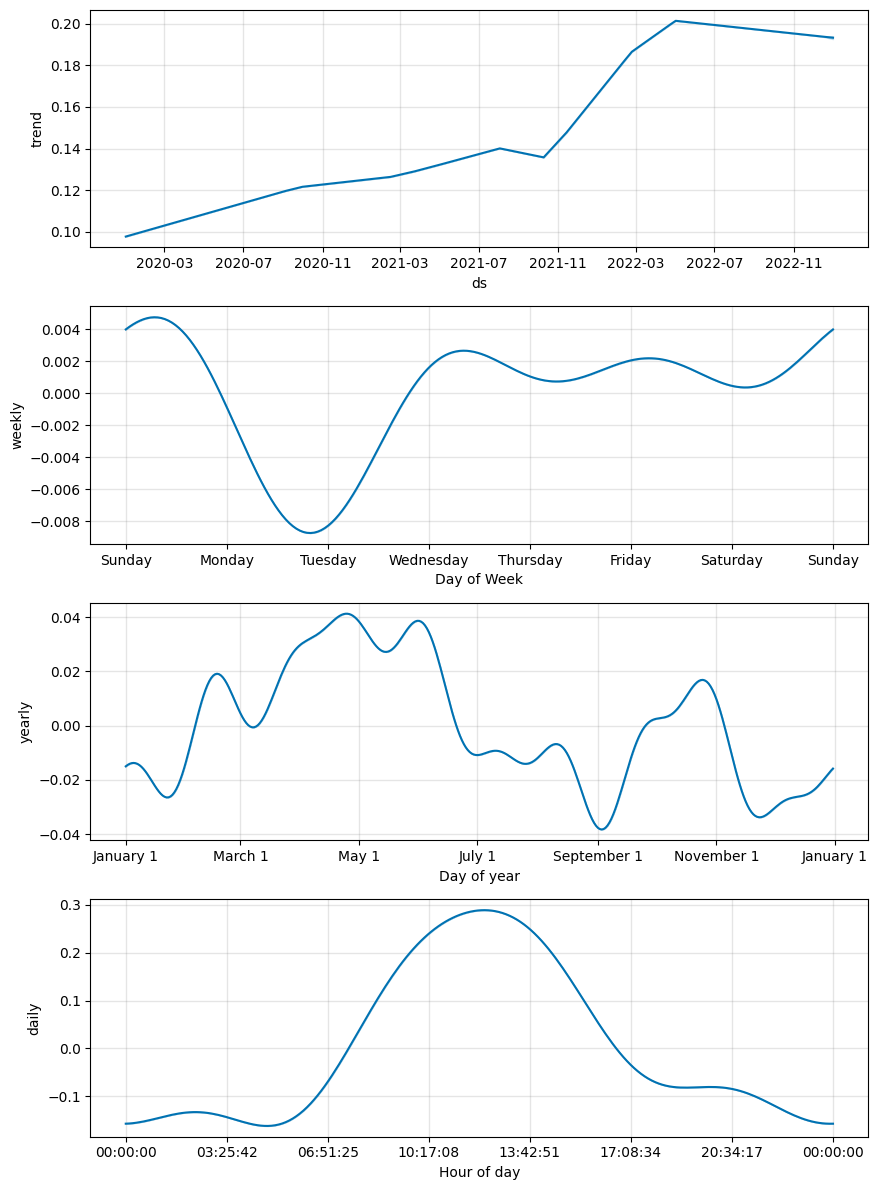

In [13]:
#예측 구성 요소 시각화
print(m.plot_components(forecast))

# neural prophet

In [14]:
! pip install neuralprophet

In [15]:
from neuralprophet import NeuralProphet, set_log_level

# Disable logging messages unless there is an error
set_log_level("ERROR")

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
#독립 변수 리스트
col_list = selected_features_train.tolist()
#모델 생성 및 학습
neural_m = NeuralProphet(learning_rate=0.5)
metrics = neural_m.fit(prophet_train[['ds', 'y']], freq="H")

Finding best initial lr:   0%|          | 0/260 [00:00<?, ?it/s]

In [ ]:
# Create a new dataframe reaching 365 into the future for our forecast, n_historic_predictions also shows historic data
neural_future = neural_m.make_future_dataframe(prophet_train[['ds', 'y']], n_historic_predictions=True, periods=len(test))

# Predict the future
forecast = neural_m.predict(neural_future)

# Visualize the forecast
neural_m.plot(forecast)